In [1]:
# 필요한 모듈 import하기

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.applications import EfficientNetB0

from glob import glob
from pprint import pprint

import os
import math
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

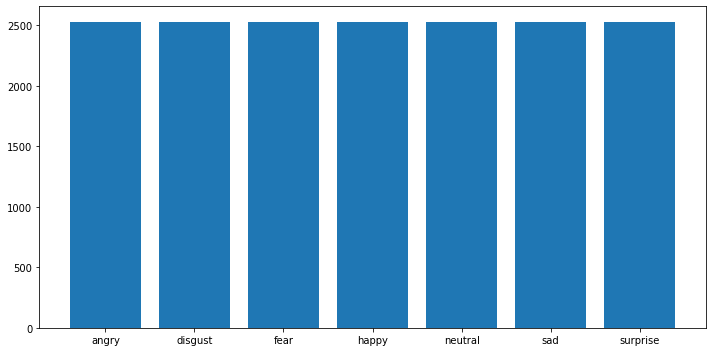

In [2]:
csv_path = './feelings_skfold2.csv'
df = pd.read_csv(csv_path)
np.unique(df['emotion'])

value_counts = df['emotion'].value_counts().sort_index()
plt.figure(figsize=(10, 5))
plt.bar(range(len(value_counts)), value_counts.values)
plt.xticks(range(len(value_counts)), value_counts.index.values)
plt.tight_layout()
plt.show()

# 1. Model 정의하기

* binary crossentropy : binary 다중 분류 손실 함수 -> label들이 독립적일 때 사용함
* categorical_crossentropy : 다중 분류 손실 함수, 출력값이 one-hot encoding된 결과로 나옴
* (정답에만 1으로 표시하고, 나머지는 0으로)
* 각 샘플이 정확히 하나의 클래스에 속하는 경우 사용한다.
* sparse_categorical_crossentropy : 다중 분류 손실 함수, one - hot - encoding을 하지 않고 정수 형태로 넣어줌, 한 샘플에 여러 클래스가 있거나 label이 soft 확률일 경우 사용

* softmax
- 출력은 0 ~ 1 사이의 실수
- 출력을 확률로 해석할 수 있음
- 출력의 총합은 1이다.

# Tensorflow Hub

* https://tfhub.dev/
* 조정 및 배포 가능한 학습된 머신러닝 모델의 저장소
* 단 몇 줄의 코드만으로 BERT 및 CNN과 같은 학습된 모델을 재사용할 수 있음

In [3]:
model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
                  trainable = True),
    tf.keras.layers.Dense(7,activation = 'softmax')
])
model.build([None,48,48,3])

adam = keras.optimizers.Adam(lr = 0.0001)
model.compile(
    optimizer = adam,
    loss = 'sparse_categorical_crossentropy',
    metrics = 'accuracy'
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              5919312   
                                                                 
 dense (Dense)               (None, 7)                 8967      
                                                                 
Total params: 5,928,279
Trainable params: 5,867,671
Non-trainable params: 60,608
_________________________________________________________________


c:\users\doroc\appdata\local\programs\python\python38\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [4]:
import albumentations as A

# Albumentation class 생성하기
class Augmentation:
    def __init__(self, size, mode='train'):
        if mode == 'train':
            self.transform = A.Compose([
                # 수평 전환
                A.HorizontalFlip(p=0.5),
                # 이동, 크기, 회전을 설정
                A.ShiftScaleRotate(
                    p=0.5,
                    shift_limit=0.05,
                    scale_limit=0.05,
                    rotate_limit=15
                ),
                # 구멍을 dropout 하게됨
                A.CoarseDropout(
                    p=0.5,
                    max_holes=8, # 최대 8개의 구멍을 dropout 시킴
                    max_height=int(0.1 * size),
                    max_width=int(0.1 * size)
                ),
                A.RandomBrightnessContrast(p=0.2) # 밝기 대비
            ])
    
    def __call__(self, **kwargs): # callback 함수: 클래스의 객체를 생성한 이후 객체를 호출할 떄 자동으로 실행되는 함수
        if self.transform:
            augmented = self.transform(**kwargs) # **kwargs : 가변 인수(파라미터의 개수에 제한을 두지 않겠다.)
            img = augmented['image'] # 증폭된 이미지
            return img 

In [5]:
csv_path = './feelings_skfold2.csv'

LABEL_INT_DICT = np.unique(pd.read_csv(csv_path)['emotion'])
pprint(LABEL_INT_DICT) # 데이터의 타입과 형태 등도 같이 보여준다.(조금 더 예쁘게 출력해준다?)
LABEL_STR_DICT = {k:v for v,k in enumerate(LABEL_INT_DICT)}
pprint(LABEL_STR_DICT)# Keras의 Sequential model 이용

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
      dtype=object)
{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}


In [6]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, fold, image_size, mode='train', shuffle=True):
        self.batch_size = batch_size
        self.fold = fold
        self.image_size = image_size
        self.mode = mode
        self.shuffle = shuffle
        
        self.df = pd.read_csv(csv_path)
        
        if self.mode == 'train':
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode == 'val':
            self.df = self.df[self.df['fold'] == self.fold]
            
        self.transform = Augmentation(image_size, mode)
        
        self.on_epoch_end()

        
    def on_epoch_end(self):
        if self.shuffle: # shuffle = True라면(df 앞의 인덱스를 지워주는 기능
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    # len()
    def __len__(self):
            return math.ceil(len(self.df) / self.batch_size)

    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx + 1) * self.batch_size
        data = self.df.iloc[strt:fin]
        batch_x, batch_y = self.get_data(data)
        return np.array(batch_x), np.array(batch_y)
        
    def get_data(self, data):
        batch_x = []
        batch_y = []
        
        for _, r in data.iterrows():
            file_name = r['file_name']
            img_folder = r['emotion'] # type = np.str_

            image = cv2.imread(f'datasets/{img_folder}/{file_name}.jpg',cv2.IMREAD_GRAYSCALE)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (self.image_size, self.image_size))
            
            if self.mode == 'train':
                image = image.astype('uint8') # 정수로 형변환
                image = self.transform(image=image)

            image = image.astype('float32') # 실수로 다시 형변환         
            image = image / 255.

            
            emotion = str(img_folder)
            emotion = LABEL_STR_DICT[emotion]
            
            batch_x.append(image)
            batch_y.append(emotion)
        
        return batch_x, batch_y
    

In [7]:
csv_path = './feelings_skfold2.csv'

train_generator = DataGenerator(
    batch_size = 128,
    csv_path = csv_path,
    fold = 1,
    image_size = 48,
    mode = 'train',
    shuffle = True
)

valid_generator = DataGenerator(
    batch_size = 128,
    csv_path = csv_path,
    fold = 1, 
    image_size = 48,
    mode = 'val',
    shuffle = True
)

In [8]:
history = model.fit(
    train_generator,
    validation_data = valid_generator,
    epochs = 50,
    verbose = 1
)

Epoch 1/50
111/111 [==============================] - 87s 716ms/step - loss: 2.0564 - accuracy: 0.1756 - val_loss: 1.8919 - val_accuracy: 0.2477
Epoch 2/50
111/111 [==============================] - 83s 747ms/step - loss: 1.9213 - accuracy: 0.2389 - val_loss: 1.7646 - val_accuracy: 0.3205
Epoch 3/50
111/111 [==============================] - 84s 754ms/step - loss: 1.8254 - accuracy: 0.2872 - val_loss: 1.6619 - val_accuracy: 0.3654
Epoch 4/50
111/111 [==============================] - 83s 752ms/step - loss: 1.7541 - accuracy: 0.3172 - val_loss: 1.5787 - val_accuracy: 0.4027
Epoch 5/50
111/111 [==============================] - 83s 746ms/step - loss: 1.6830 - accuracy: 0.3555 - val_loss: 1.5130 - val_accuracy: 0.4179
Epoch 6/50
111/111 [==============================] - 88s 793ms/step - loss: 1.6169 - accuracy: 0.3890 - val_loss: 1.4587 - val_accuracy: 0.4393
Epoch 7/50
111/111 [==============================] - 85s 769ms/step - loss: 1.5685 - accuracy: 0.4077 - val_loss: 1.4155 - val_ac

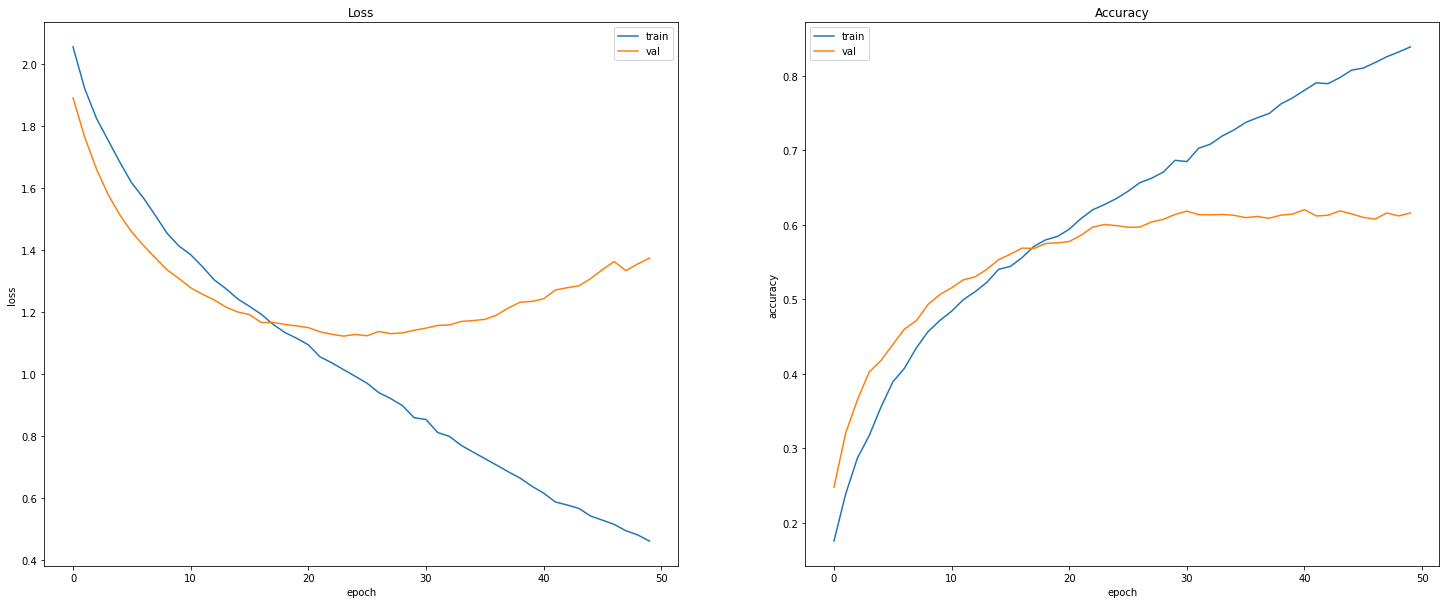

In [9]:
history = history.history

plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("Accuracy")
plt.show()